In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt 

In [2]:
data_2 = np.load('2_qubit_data.npz')
data_4 = np.load('4_qubit_data.npz')
data_6 = np.load('6_qubit_data.npz')
data_7 = np.load('7_qubit_data.npz')

In [3]:
data = [data_2, data_4, data_6, data_7]

In [21]:
training_data_y_2 = data[0]['ground_state']
training_data_x_2 = data[0]['fields'][:,[0,2,4]]
num_qubits_column = 2 * (np.ones((100, 1)))
training_data_x_2 = np.hstack((training_data_x_2, num_qubits_column))
print(training_data_x_2.shape)

(100, 4)


In [24]:
training_data_y_6 = data[2]['ground_state']
training_data_x_6 = data[2]['fields'][:,[0,6,12]]
num_qubits_column = 6 * (np.ones((1000, 1)))
training_data_x_6 = np.hstack((training_data_x_6, num_qubits_column))
print(training_data_x_6.shape)

(1000, 4)


In [26]:
training_data_2 = TensorDataset(torch.Tensor(training_data_x_2), torch.Tensor(training_data_y_2))
training_data_6 = TensorDataset(torch.Tensor(training_data_x_6), torch.Tensor(training_data_y_6))

In [29]:
val_data_y_4 = data[1]['ground_state']
val_data_x_4 = data[1]['fields'][:,[0,4,8]]
num_qubits_column = 4 * (np.ones((1000, 1)))
val_data_x_4 = np.hstack((val_data_x_4, num_qubits_column))
print(val_data_x_4.shape)

val_data_y_7 = data[3]['ground_state']
val_data_x_7 = data[3]['fields'][:,[0,7,14]]
num_qubits_column = 7 * (np.ones((1000, 1)))
val_data_x_7 = np.hstack((val_data_x_7, num_qubits_column))
print(val_data_x_7.shape)

(1000, 4)
(1000, 4)


In [30]:
val_data_4 = TensorDataset(torch.Tensor(val_data_x_4), torch.Tensor(val_data_y_4))
val_data_7 = TensorDataset(torch.Tensor(val_data_x_7), torch.Tensor(val_data_y_7))

In [31]:
def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp   

In [90]:
class MPS_autoencoder(nn.Module):
    def __init__(self, mps_size):
        super(MPS_autoencoder, self).__init__()        
        self.mps_size = mps_size
        self.encoder = nn.Sequential(nn.Linear(4,8),
                                nn.ReLU(),
                                nn.Linear(8,16),
                                nn.ReLU(),
                                nn.Linear(16,2 * (mps_size ** 2))
                               )
    def encode(self, x):
        encoded = self.encoder(x)
        temp = encoded.view(-1, 2,self.mps_size,self.mps_size)
        spin_up, spin_down = torch.split(temp, 1, dim = 1)
        return spin_up, spin_down
    
    def decode(self, spin_up, spin_down, num_qubits):
        # spin_up and spin_down (1,mps.size,mps.size)
        mps = {'0':spin_up, '1':spin_down}
                
        coeffs = [] 
        
        states = seq_gen(num_qubits)
        for state in states:
            mat = mps[state[0]]
            
            for site in state[1:]:
                mat = torch.matmul(mat, mps[site])
            diagonal = torch.diagonal(mat, dim1=-1,dim2=-2)
            coeffs.append(torch.sum(diagonal, dim = -1, keepdim = True))
                
        
        c_i = coeffs[0]
        for i in coeffs[1:]:
            c_i = torch.cat((c_i, i), dim = 1)
        return c_i.squeeze()
    
    def forward(self, x, num_qubits):
        spin_up, spin_down = self.encode(x)
        gs = self.decode(spin_up, spin_down, num_qubits)
        gs = gs / torch.norm(gs, dim = 1).view(-1,1)
        return gs

In [33]:
training_loader_2 = DataLoader(training_data_2, batch_size = 32)
training_loader_6 = DataLoader(training_data_6, batch_size = 32)

val_loader_4 = DataLoader(val_data_4, batch_size = 256)
val_loader_7 = DataLoader(val_data_7, batch_size = 256)

In [87]:
def tune_mps(mps_size, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MPS_autoencoder(mps_size = mps_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_func = nn.MSELoss(reduction='sum')
    
    qubit_2_loss = []
    qubit_4_loss = []
    
    qubit_6_loss = []
    qubit_7_loss = []
    
    total_training_loss = []
    total_val_loss = []
    
    for epoch in range(num_epochs):
        total_2 = 0
        
        for i,(fields,wf) in enumerate(training_loader_2):
            fields = fields
            gs = model(fields, 2)
            loss = loss_func(gs, wf)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_2 += loss.item()
        total_6 = 0
        for i,(fields,wf) in enumerate(training_loader_6):
            fields = fields
            gs = model(fields, 6)
            loss = loss_func(gs, wf)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_6 += loss.item()
        avg_2 = total_2 / (len(training_loader_2))
        avg_6 = total_6 / (len(training_loader_6))
            
        total =  avg_2 + avg_6
        
        qubit_2_loss.append(avg_2)
        qubit_6_loss.append(avg_6)
        total_training_loss.append(total)
    
    
        with torch.no_grad():
            total_4 = 0
            total_7 = 0
            for i,(fields,wf) in enumerate(val_loader_4):
                gs = model(fields, 4)
                loss = loss_func(gs, wf)
                total_4 += loss.item()
            avg_4 = total_4 / len(val_loader_4)

            for i,(fields,wf) in enumerate(val_loader_7):
                gs = model(fields, 7)
                loss = loss_func(gs, wf)
                total_7 += loss.item()
            avg_7 = total_7 / len(val_loader_7)
            val_loss = avg_4 + avg_7 
            qubit_4_loss.append(avg_4)
            qubit_7_loss.append(avg_7)
            total_val_loss.append(val_loss)
        if (epoch % 10 == 0):
                print("Epoch {} : {} \t\t | 2_qubit loss: {} \t | 6_qubit_loss: {}".format(epoch + 1, total, avg_2, avg_6))
                print("Epoch {} : {} \t\t | 4_qubit loss: {} \t | 7_qubit_loss: {}".format(epoch + 1, val_loss, avg_4, avg_7))
                print('*' * 100)

    return model, (qubit_2_loss,qubit_4_loss,qubit_6_loss,qubit_7_loss,total_training_loss,total_val_loss)

In [ ]:
errors = tune_mps(2)

In [ ]:
errors_mps_4 = tune_mps(4)

In [ ]:
errors = [] 
for i in range(5,8):
    errors.append(tune_mps(i))

In [61]:
two_l, four_l, six_l, seven_l, tot_l, val_l = errors[1]

Text(0.5, 0, 'Epochs')

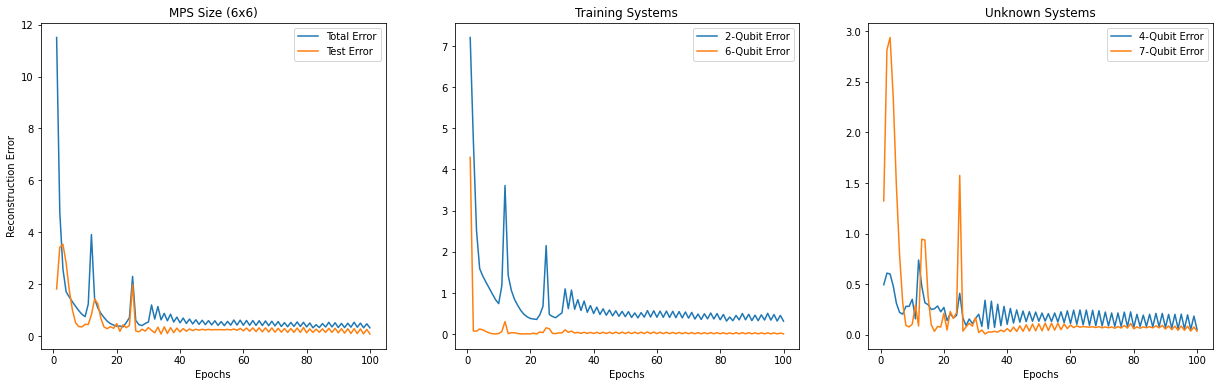

In [82]:
x = np.arange(1,101)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

ax1.plot(x,tot_l, label='Total Error')
ax1.plot(x,val_l, label='Test Error')
ax1.legend()
ax1.set_title('MPS Size (6x6)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Reconstruction Error')

ax2.plot(x,two_l, label='2-Qubit Error')
ax2.plot(x,six_l, label='6-Qubit Error')
ax2.legend()
ax2.set_title('Training Systems')
ax2.set_xlabel('Epochs')

ax3.plot(x,four_l, label='4-Qubit Error')
ax3.plot(x,seven_l, label='7-Qubit Error')
ax3.legend()
ax3.set_title('Unknown Systems')
ax3.set_xlabel('Epochs')


In [91]:
model, (two_l, four_l, six_l, seven_l, tot_l, val_l) = tune_mps(6,200)

Epoch 1 : 10.188287878845586 		 | 2_qubit loss: 9.580182790756226 	 | 6_qubit_loss: 0.6081050880893599
Epoch 1 : 3.541300907731056 		 | 4_qubit loss: 0.5784926563501358 	 | 7_qubit_loss: 2.9628082513809204
****************************************************************************************************
Epoch 11 : 2.383896998681621 		 | 2_qubit loss: 2.3296463042497635 	 | 6_qubit_loss: 0.05425069443185748
Epoch 11 : 1.234158731997013 		 | 4_qubit loss: 0.8596795052289963 	 | 7_qubit_loss: 0.3744792267680168
****************************************************************************************************
Epoch 21 : 0.6672098746948905 		 | 2_qubit loss: 0.6620307941921055 	 | 6_qubit_loss: 0.005179080502784927
Epoch 21 : 0.38672060694079846 		 | 4_qubit loss: 0.3573523238301277 	 | 7_qubit_loss: 0.029368283110670745
****************************************************************************************************
Epoch 31 : 0.6537617431176841 		 | 2_qubit loss: 0.6490324875921942

(0.0, 3.5)

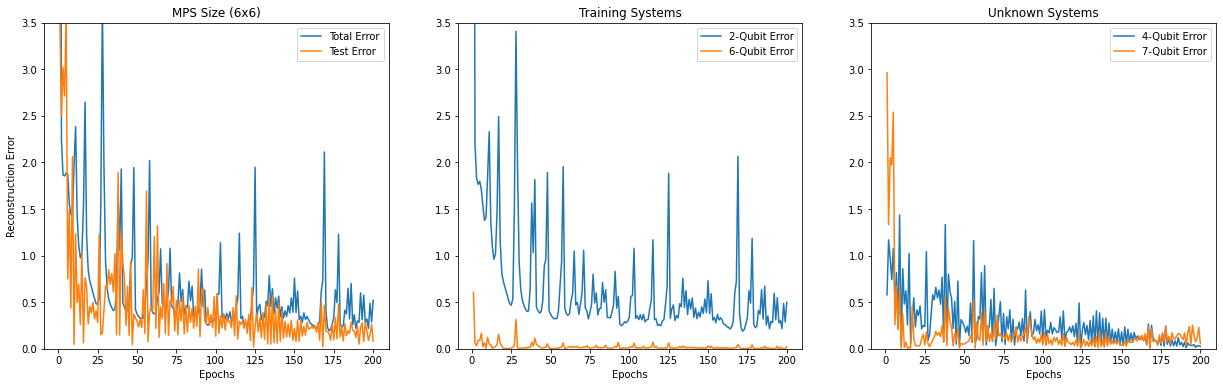

In [94]:
x = np.arange(1,201)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

ax1.plot(x,tot_l, label='Total Error')
ax1.plot(x,val_l, label='Test Error')
ax1.legend()
ax1.set_title('MPS Size (6x6)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Reconstruction Error')
ax1.set_ylim([0,3.5])

ax2.plot(x,two_l, label='2-Qubit Error')
ax2.plot(x,six_l, label='6-Qubit Error')
ax2.legend()
ax2.set_title('Training Systems')
ax2.set_xlabel('Epochs')
ax2.set_ylim([0,3.5])

ax3.plot(x,four_l, label='4-Qubit Error')
ax3.plot(x,seven_l, label='7-Qubit Error')
ax3.legend()
ax3.set_title('Unknown Systems')
ax3.set_xlabel('Epochs')
ax3.set_ylim([0,3.5])

In [ ]:
model.eval()
with torch.no_grad():
    encoded_spin_up = []
    encoded_spin_down = []
    for i,(fields,wf) in enumerate(val_loader_4):
        spin_up, spin_down = model.encode(fields)
        print(spin_up.squeeze().shape)
        print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(val_loader_7):
        spin_up, spin_down = model.encode(fields)
        print(spin_up.squeeze().shape)
        print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(training_loader_2):
        spin_up, spin_down = model.encode(fields)
        print(spin_up.squeeze().shape)
        print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(training_loader_6):
        spin_up, spin_down = model.encode(fields)
        print(spin_up.squeeze().shape)
        print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())  

In [108]:
data_up = encoded_spin_up[0].numpy()
data_down = encoded_spin_down[0].numpy()
for i in range(1, len(encoded_spin_up)):
    data_up = np.vstack((data_up, encoded_spin_up[i].numpy()))
    data_down = np.vstack((data_down, encoded_spin_down[i].numpy()))
    
print(data_up.shape)
print(data_down.shape)

(3100, 6, 6)
(3100, 6, 6)


In [113]:
data_up = data_up.reshape((3100,36))
data_down = data_down.reshape((3100,36))

(3100, 72)
(1000,)


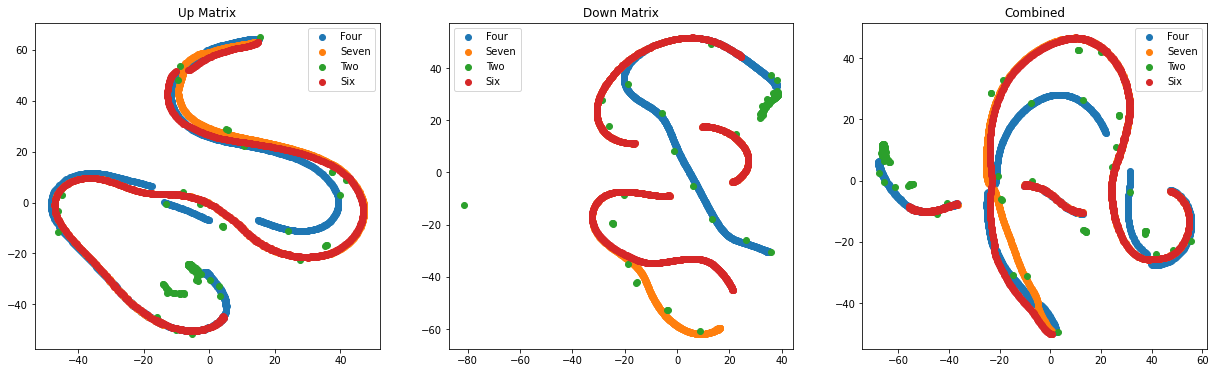

In [140]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

up=data_up
down=data_down
data = np.hstack((data_up, data_down))

print(data.shape)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

pca = TSNE(n_components=2, perplexity=50)

up = pca.fit_transform(up)
down = pca.fit_transform(down)
data = pca.fit_transform(data)

print(up[:1000][:,0].shape)
ax1.scatter(up[:1000][:,0],up[:1000][:,1] ,label='Four')
ax1.scatter(up[1000:2000][:,0],up[1000:2000][:,1] ,label='Seven')
ax1.scatter(up[2000:2100][:,0],up[2000:2100][:,1] ,label='Two')
ax1.scatter(up[2100:][:,0],up[2100:][:,1] ,label='Six')
ax1.set_title('Up Matrix')

ax1.legend()

ax2.scatter(down[:1000][:,0],down[:1000][:,1] ,label='Four')
ax2.scatter(down[1000:2000][:,0],down[1000:2000][:,1] ,label='Seven')
ax2.scatter(down[2000:2100][:,0],down[2000:2100][:,1] ,label='Two')
ax2.scatter(down[2100:][:,0],down[2100:][:,1] ,label='Six')
ax2.set_title('Down Matrix')

ax2.legend()

ax3.scatter(data[:1000][:,0],data[:1000][:,1] ,label='Four')
ax3.scatter(data[1000:2000][:,0],data[1000:2000][:,1] ,label='Seven')
ax3.scatter(data[2000:2100][:,0],data[2000:2100][:,1] ,label='Two')
ax3.scatter(data[2100:][:,0],data[2100:][:,1] ,label='Six')
ax3.set_title('Combined')
ax3.legend()




(1000,)


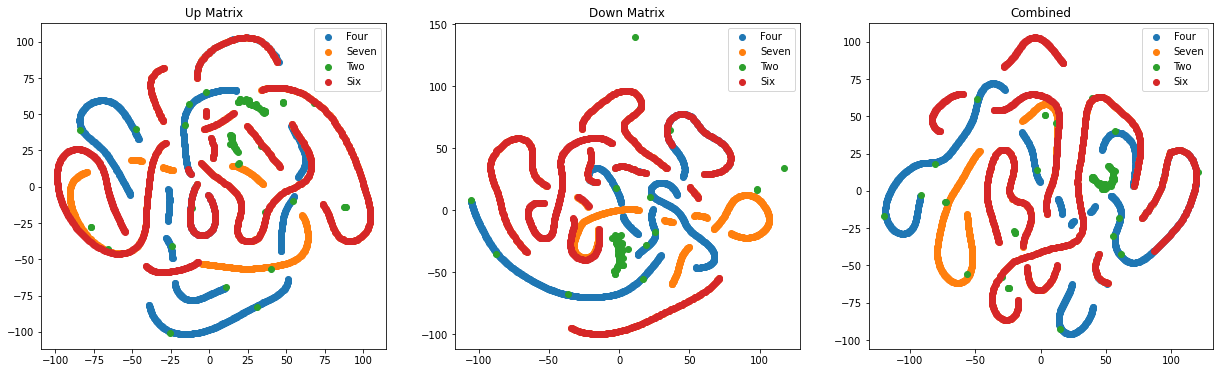

In [138]:
from sklearn.decomposition import PCA
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

pca = PCA(n_components=2)

up = pca.fit_transform(up)
down = pca.fit_transform(down)
data = pca.fit_transform(data)

print(up[:1000][:,0].shape)
ax1.scatter(up[:1000][:,0],up[:1000][:,1] ,label='Four')
ax1.scatter(up[1000:2000][:,0],up[1000:2000][:,1] ,label='Seven')
ax1.scatter(up[2000:2100][:,0],up[2000:2100][:,1] ,label='Two')
ax1.scatter(up[2100:][:,0],up[2100:][:,1] ,label='Six')
ax1.set_title('Up Matrix')

ax1.legend()

ax2.scatter(down[:1000][:,0],down[:1000][:,1] ,label='Four')
ax2.scatter(down[1000:2000][:,0],down[1000:2000][:,1] ,label='Seven')
ax2.scatter(down[2000:2100][:,0],down[2000:2100][:,1] ,label='Two')
ax2.scatter(down[2100:][:,0],down[2100:][:,1] ,label='Six')
ax2.set_title('Down Matrix')

ax2.legend()

ax3.scatter(data[:1000][:,0],data[:1000][:,1] ,label='Four')
ax3.scatter(data[1000:2000][:,0],data[1000:2000][:,1] ,label='Seven')
ax3.scatter(data[2000:2100][:,0],data[2000:2100][:,1] ,label='Two')
ax3.scatter(data[2100:][:,0],data[2100:][:,1] ,label='Six')
ax3.set_title('Combined')
ax3.legend()